In [1]:
import os
import math
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
%matplotlib inline

SEED=1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
class QTS_OPTIMIZER(nn.Module):
    def __init__(self,ticker_pair,start_date,end_date,riskfree_rate=0.04):
        super(QTS_OPTIMIZER,self).__init__()
        self.ticker_pair=ticker_pair
        self.start_date=start_date
        self.end_date=end_date
        self.riskfree_rate=riskfree_rate
        self.stock=self.get_stock_data()
        
    def get_stock_data(self):
        print('=====DOWNLOADING STOCK DATA=====')
        df= yf.download(self.ticker_pair,start=self.start_date,end=self.end_date)['Adj Close']
        print('====DOWNLOAD COMPLETE====')
        return pd.DataFrame(df)
    
    def forward(self,entry_threshold,exit_threshold,window_size=10):
        #add sma columns
        stock_df=self.stock.copy()
        
        #Calculate the spread for GOOG and MSFT
        Y= stock_df[self.ticker_pair[0]]
        X=stock_df[self.ticker_pair[1]]
        
        #estimate linear regression coefficients
        X_with_constant=sm.add_constant(X)
        model=OLS(Y, X_with_constant).fit()
        
        #obtain the spread as the residuals
        spread=Y- model.predict()
        
        #calculate the rolling mean and sd
        spread_mean=spread.rolling(window=window_size).mean()
        spread_std=spread.rolling(window=window_size).std()
        zscore=(spread-spread_mean)/spread_std
        
        #remove initial days with NA
        first_valid_idx=zscore.first_valid_index()
        zscore=zscore[first_valid_idx:]
        
        #initialise the daily positions to be zeros
        stock1_position=pd.Series(data=0, index=zscore.index)
        stock2_position=pd.Series(data=0, index=zscore.index)
        
        #generate daily entry and exit signals for each stock
        for i in range(1,len(zscore)):
            #zscore < -entry_threshold and no existing long position for stock1
            if zscore[i]< -entry_threshold and stock1_position[i-1]==0:
                stock1_position[i]=1 #long stock1
                stock2_position[i]= -1 #short stock2
            #zscore > entry_threshold and no existing short position for stock2
            elif zscore[i]>entry_threshold and stock2_position[i-1]==0:
                stock1_position[i]= -1 #short stock 1
                stock2_position[i]=1 #long stock 2
            
            #-exit_threshold<zscore<exit_threshold:
            elif abs(zscore[i])<exit_threshold:
                stock1_position[i]=0 # exit existing position
                stock2_position[i]=0
            
            #-entry_threshold<zscore<-exit_threshold or exit_threshold<zscore<entry_threshold
            else:
                #maintain existing positions
                stock1_position[i]=stock1_position[i-1]
                stock2_position[i]=stock2_position[i-1]
                
        #calculate the returns of each stock
        stock1_returns=(Y[first_valid_idx:].pct_change()*stock1_position.shift(1)).fillna(0)
        stock2_returns=(X[first_valid_idx:].pct_change()*stock2_position.shift(1)).fillna(0)
        
        #calculate total returns
        total_returns=stock1_returns + stock2_returns
        #calculate annualised return
        annualised_return=(1+total_returns).prod()**(252/Y[first_valid_idx:].shape[0])-1
        
        #annualised volatility
        annualised_volatility=total_returns.std()*(252**0.5)
        if annualised_volatility==0:
            annualised_volatility=100
        
        #calculate Sharpe Ratio
        sharpe_ratio=(annualised_return-self.riskfree_rate)/annualised_volatility
        
        return sharpe_ratio
        

In [3]:
qts=QTS_OPTIMIZER(ticker_pair=['GOOGL','MSFT'],start_date='2022-01-01',end_date='2023-01-01')

=====DOWNLOADING STOCK DATA=====
[*********************100%%**********************]  2 of 2 completed
====DOWNLOAD COMPLETE====


In [4]:
qts.stock.head()

,GOOGL,MSFT
Date,,
2022-01-03,144.991501,329.394897
2022-01-04,144.399506,323.746735
2022-01-05,137.774994,311.318756
2022-01-06,137.747498,308.858765
2022-01-07,137.016998,309.016174


**obtaining Sharpe ratio from forward function with different ENTRY/EXIT values**

In [5]:
qts(entry_threshold=2,exit_threshold=1)

2.728937735336866

In [6]:
qts(entry_threshold=1.5,exit_threshold=0.5)

3.1377051767216106

**Generating Training Set for Bayesian OPTIMIZATION**

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype=torch.double
x1_bound=[1,3]
x2_bound=[0,1]


In [8]:
def generate_initial_data(n=10):
    #generate random initial locations
    train_x1=x1_bound[0]+(x1_bound[1]-x1_bound[0])*torch.rand(size=(n,1),device=device, dtype=dtype)
    train_x2=torch.rand(size=(n,1),device=device,dtype=dtype)
    train_x=torch.cat((train_x1,train_x2),1)
    
    #obtain the exact value of the objective function and add output dimension
    train_y= []
    for i in range(len(train_x)):
        train_y.append(qts(entry_threshold=train_x1[i],exit_threshold=train_x2[i]))
    train_y=torch.Tensor(train_y,device=device).to(dtype).unsqueeze(-1)
        
        #get the current observed value, i.e, utility of the available dataset
    best_observed_value=train_y.max().item()
    return train_x,train_y,best_observed_value

In [9]:
#Generate 3 samples in the training
train_x,train_y,best_observed_value=generate_initial_data(n=3)
print(train_x)
print(train_y)
print(best_observed_value)

tensor([[1.1221, 0.1771],
        [1.4491, 0.5561],
        [1.4685, 0.1094]], dtype=torch.float64)
tensor([[0.1656],
        [2.5359],
        [0.5458]], dtype=torch.float64)
2.535926580429077


**Implementing the Gaussian Process Model**

In [10]:
#initialise GP model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

def initialise_model(train_x,train_y):
    #create a single-task exact GP model instance
    #use a GP prior with Matern kernel and constant mean function by default
    model=SingleTaskGP(train_X=train_x,train_Y=train_y)
    mll=ExactMarginalLogLikelihood(model.likelihood,model)
    return mll, model

In [11]:
mll,model=initialise_model(train_x,train_y)
list(model.named_hyperparameters())

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([2.0000], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0., 0.]], dtype=torch.float64, requires_grad=True))]

In [12]:
#optimize GP hyperparameters
from botorch.fit import fit_gpytorch_mll
#fit hyperparameters(kernel parameters and noise variance) of a GPytorch model
fit_gpytorch_mll(mll.cpu());
mll=mll.to(train_x)
model=model.to(train_x)

list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([0.4269], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(1.2187, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(2.2432, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.7764, -1.0701]], dtype=torch.float64, requires_grad=True))]

**Guiding the sequential Search by Maximising the Acquisition Function**

In [13]:
#define acquisition function
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient

#call helper functions to generate initial training data and initialise model
train_x,train_y,best_observed_value=generate_initial_data(n=3)
train_x_ei=train_x
train_x_qei=train_x
train_x_ucb=train_x
train_x_qkg=train_x
train_y_ei=train_y
train_y_qei=train_y
train_y_ucb=train_y
train_y_qkg=train_y

mll_ei,model_ei=initialise_model(train_x_ei,train_y_ei)
mll_qei,model_qei=initialise_model(train_x_qei,train_y_qei)
mll_ucb,model_ucb=initialise_model(train_x_ucb,train_y_ucb)
mll_qkg,model_qkg=initialise_model(train_x_qkg,train_y_qkg)

EI=ExpectedImprovement(model=model_ei, best_f=best_observed_value)
qEI=qExpectedImprovement(model=model_qei, best_f=best_observed_value)
beta=0.8
UCB=UpperConfidenceBound(model=model_ucb, beta=beta)
num_fantasies=64
qKG=qKnowledgeGradient(model=model_qkg,num_fantasies=num_fantasies,X_baseline=train_x,q=1)


C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [14]:
#optimize and get new observation
from botorch.optim import optimize_acqf

#get search bounds
bounds=torch.tensor([[x1_bound[0],x2_bound[0]],[x1_bound[1],x2_bound[1]]],device=device, dtype=dtype)

#parallel candidate locations generated in each iteration
BATCH_SIZE=1

#number of starting points for multistart optimisation
NUM_RESTARTS=10

#number of samples for initialisation
RAW_SAMPLES=1024

def optimize_acqf_and_get_observation(acq_func):
    '''
    Optimizes the acquisition function, and returns a new candidate and a noisy observation
    '''
    #optimize
    candidates,value= optimize_acqf(acq_function=acq_func,
                                   bounds=bounds,
                                   q=BATCH_SIZE,
                                   num_restarts=NUM_RESTARTS,
                                   raw_samples=RAW_SAMPLES, #used for initialisation heuristic
                                   )
    #observe new values
    new_x=candidates.detach()
    #sample output value
    new_y=qts(entry_threshold=new_x.squeeze()[0].item(), exit_threshold=new_x.squeeze()[1].item())
    #add output dimension
    new_y=torch.Tensor([new_y], device=device).to(dtype).unsqueeze(-1)
    #print('new fn value:',new_y)
    
    return new_x,new_y

In [15]:
#Let us test out the function with qKG acquisition function
optimize_acqf_and_get_observation(EI)

(tensor([[1.6114, 0.5563]], dtype=torch.float64),
 tensor([[2.8056]], dtype=torch.float64))

In [16]:
#test out random searxh strategy which selects a random window length for each moving series at each round

def update_random_observations(best_random):
    '''
    Simulates a random policy by drawing new random points,
    observing their values and updating the current best candidate to the running list
    '''
    new_x1=x1_bound[0] + (x1_bound[1]- x1_bound[0])* torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x2=torch.rand(size=(1,1), device=device, dtype=dtype)
    new_x=torch.cat((new_x1,new_x2), 1)
    new_y=qts(entry_threshold=new_x[0,0].item(), exit_threshold=new_x[0,1].item())
    best_random.append(max(best_random[-1],new_y))
    return best_random

**Performing Sequential Search**

effective strategy identifies the highest Sharpe ratio faster than alternative strategies under the same environment setting

In [17]:
##single trial
import time
N_ROUND=20
VERBOSE=True
beta=0.8

best_random,best_observed_ei,best_observed_qei,best_observed_ucb,best_observed_qkg=[],[],[],[],[]

best_random.append(best_observed_value)
best_observed_ei.append(best_observed_value)
best_observed_qei.append(best_observed_value)
best_observed_ucb.append(best_observed_value)
best_observed_qkg.append(best_observed_value)

#run N_ROUND rounds of BayesOpt after initial random batch
for iteration in range(1,N_ROUND+1):
    t0=time.monotonic()
    #fit the modles
    fit_gpytorch_mll(mll_ei)
    fit_gpytorch_mll(mll_qei)
    fit_gpytorch_mll(mll_ucb)
    fit_gpytorch_mll(mll_qkg)
    
    #for best_f, we use the best observed exact values
    EI=ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
    qEI=qExpectedImprovement(model=model_qei,best_f=train_y_qei.max(),num_samples=1024)
    UCB=UpperConfidenceBound(model=model_ucb,beta=beta)
    qKG=qKnowledgeGradient(model=model_qkg, num_fantasies=64, objective=None, X_baseline=train_x_qkg,)
    
    #optimise and get new observation
    new_x_ei,new_y_ei=optimize_acqf_and_get_observation(EI)
    new_x_qei,new_y_qei=optimize_acqf_and_get_observation(qEI)
    new_x_ucb,new_y_ucb=optimize_acqf_and_get_observation(UCB)
    new_x_qkg,new_y_qkg=optimize_acqf_and_get_observation(qKG)
    
    #update training points
    train_x_ei=torch.cat([train_x_ei,new_x_ei], dim=0)
    train_x_qei=torch.cat([train_x_qei, new_x_qei], dim=0)
    train_x_ucb=torch.cat([train_x_ucb, new_x_ucb], dim=0)
    train_x_qkg=torch.cat([train_x_qkg, new_x_qkg], dim=0)
    train_y_ei=torch.cat([train_y_ei, new_y_ei], dim=0)
    train_y_qei=torch.cat([train_y_qei, new_y_qei], dim=0)
    train_y_ucb=torch.cat([train_y_ucb, new_y_ucb], dim=0)
    train_y_qkg=torch.cat([train_y_qkg, new_y_qkg], dim=0)
    
    #update progress
    best_random=update_random_observations(best_random)
    best_value_ei=max(best_observed_ei[-1],new_y_ei.item())
    best_value_qei=max(best_observed_qei[-1],new_y_qei.item())
    best_value_ucb=max(best_observed_ucb[-1],new_y_ucb.item())
    best_value_qkg=max(best_observed_qkg[-1],new_y_qkg.item())
    
    best_observed_ei.append(best_value_ei)
    best_observed_qei.append(best_value_qei)
    best_observed_ucb.append(best_value_ucb)
    best_observed_qkg.append(best_value_qkg)
    
    #reinitialise the models so they are ready for fitting on the next iteration
    mll_ei,model_ei=initialise_model(train_x_ei,train_y_ei)
    mll_qei,model_qei=initialise_model(train_x_qei,train_y_qei)
    mll_ucb,model_ucb=initialise_model(train_x_ucb,train_y_ucb)
    mll_qkg,model_qkg=initialise_model(train_x_qkg,train_y_qkg)
    
    t1=time.monotonic()

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\

C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\envs\Torch\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
C:\Users\DELL\anaconda3\

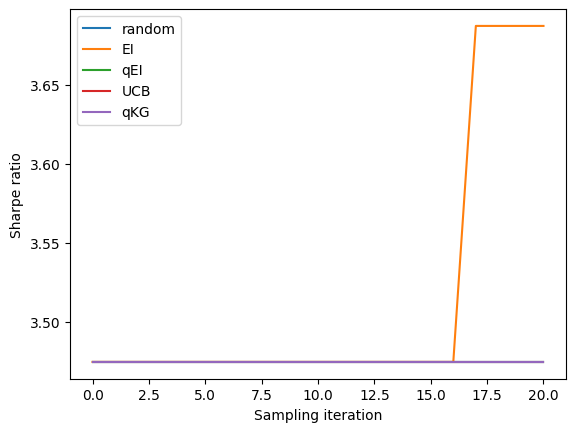

In [19]:
iters=np.arange(N_ROUND +1)* BATCH_SIZE
plt.plot(iters, best_random, label='random')
plt.plot(iters, best_observed_ei, label= 'EI')
plt.plot(iters, best_observed_qei, label= 'qEI')
plt.plot(iters, best_observed_ucb, label= 'UCB')
plt.plot(iters, best_observed_qkg, label= 'qKG')
plt.legend()
plt.xlabel('Sampling iteration')
plt.ylabel('Sharpe ratio')
plt.show()